<a href="https://colab.research.google.com/github/giuseppeegentile/2d-convolution-cuda/blob/main/Copia_di_Working_2d_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-b2teuotl
  Running command git clone -q https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-b2teuotl
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4306 sha256=841f72f99a620992c9e9ee025ef50828edeff5d5b032379516364bccd6e3897b
  Stored in directory: /tmp/pip-ephem-wheel-cache-7_hu9beo/wheels/ca/33/8d/3c86eb85e97d2b6169d95c6e8f2c297fdec60db6e84cb56f5e
Successfully built NVCCPlugin


In [ ]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


# Untiled case

In [ ]:
%%cu
#include <cuda.h>
#include <stdio.h>
#include <time.h>
#include <stdlib.h>

#define BLOCK_WIDTH 32
#define MATRIX_SIZE 1024

__global__ void untiledConvolution_2D_Kernel(unsigned char* inp, const unsigned char* d_mask, unsigned char* out, size_t maskWidth) {
    unsigned char result = 0;
   
    // indexing variables
    int outRow = blockIdx.y * blockDim.y + threadIdx.y;
    int outCol = blockIdx.x * blockDim.x + threadIdx.x;
    
    if(outRow < MATRIX_SIZE && outCol < MATRIX_SIZE){
      int inputRow = outRow - maskWidth / 2;
      int inputCol = outCol - maskWidth / 2;
      
      for(int i = 0; i < maskWidth; ++i){
          for(int j = 0; j < maskWidth; ++j){
              int curCol = inputCol + j;
              int curRow = inputRow + i;
              if (curCol < MATRIX_SIZE && curRow < MATRIX_SIZE && curCol > -1 && curRow > -1) 
                result += inp[curRow * MATRIX_SIZE + curCol] * d_mask[i * maskWidth + j];
          }
    
      
      // write result
      out[outRow * MATRIX_SIZE + outCol] = result;
      }
    }
}


void launch_kernel(unsigned char* m, unsigned char* mask, unsigned char* n, size_t maskWidth) {
    float  naive_gpu_elapsed_time_ms;
    //clock_t st, end;
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    dim3 dimGrid(ceil(MATRIX_SIZE + BLOCK_WIDTH - 1/BLOCK_WIDTH), ceil(MATRIX_SIZE + BLOCK_WIDTH - 1/  BLOCK_WIDTH), 1);
    dim3 dimBlock(BLOCK_WIDTH, BLOCK_WIDTH, 1);

    unsigned char* d_m;
    unsigned char* d_mask;
    unsigned char* d_n;

    cudaMalloc((void**) &d_m, MATRIX_SIZE * MATRIX_SIZE * sizeof(unsigned char));
    cudaMalloc((void**) &d_mask, maskWidth * maskWidth * sizeof(unsigned char));
    cudaMalloc((void**) &d_n, MATRIX_SIZE * MATRIX_SIZE * sizeof(unsigned char));
    
    cudaMemcpy(d_m, m, MATRIX_SIZE * MATRIX_SIZE * sizeof(unsigned char), cudaMemcpyHostToDevice);
    cudaMemcpy(d_mask, mask, maskWidth * maskWidth * sizeof(unsigned char), cudaMemcpyHostToDevice);
    cudaEventRecord(start, 0);
    untiledConvolution_2D_Kernel<<<dimGrid, dimBlock>>>(d_m, d_mask, d_n, maskWidth);
    

    cudaThreadSynchronize();

    //time counting terminate
    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&naive_gpu_elapsed_time_ms, start, stop);
    printf("Mask size: %d\n", maskWidth);
    printf("Time elapsed on naive GPU convolution 2d untiled ( %d ) block %f ms.\n\n", BLOCK_WIDTH, naive_gpu_elapsed_time_ms);
    printf("______________________________________________________________________________\n");
    cudaMemcpy(n, d_n, MATRIX_SIZE * MATRIX_SIZE * sizeof(float), cudaMemcpyDeviceToHost);

    cudaFree(d_m);
    cudaFree(d_mask);
    cudaFree(d_n);
}

int main() {
     for(size_t maskWidth = 11; maskWidth <= 17; maskWidth+=2){
      unsigned char* inp = (unsigned char*) malloc(MATRIX_SIZE * MATRIX_SIZE * sizeof(unsigned char));
      unsigned char* mask = (unsigned char*) malloc(maskWidth * maskWidth * sizeof(unsigned char));
      unsigned char* out = (unsigned char*) malloc(MATRIX_SIZE * MATRIX_SIZE * sizeof(unsigned char));

      for(int i = 0; i < MATRIX_SIZE * MATRIX_SIZE; ++i) {
          inp[i] = (unsigned char)(1 +(3 * i % 20));
      }
    
      for(int j = 0; j < maskWidth * maskWidth; ++j) {
          mask[j] = (unsigned char)(1 + (((2 * j)) % maskWidth));
      }
     
      launch_kernel(inp, mask, out, maskWidth);
    }
    return 0;
}

Mask size: 11
Time elapsed on naive GPU convolution 2d untiled ( 32 ) block 18.751616 ms.

______________________________________________________________________________
Mask size: 13
Time elapsed on naive GPU convolution 2d untiled ( 32 ) block 18.993153 ms.

______________________________________________________________________________
Mask size: 15
Time elapsed on naive GPU convolution 2d untiled ( 32 ) block 19.427328 ms.

______________________________________________________________________________
Mask size: 17
Time elapsed on naive GPU convolution 2d untiled ( 32 ) block 19.746496 ms.

______________________________________________________________________________



# Tiling

In [ ]:
%%cu
#include <cuda.h>
#include <stdio.h>
#include <time.h>
#include <stdlib.h>

#define BLOCK_WIDTH 32
#define MATRIX_SIZE 1024


__global__ void tiledConvolution_2D_Kernel(unsigned char* inp, const unsigned char* mask, unsigned char* out, size_t maskWidth, int N_TILE_WIDTH) {
    unsigned char result = 0;
   
    int outputRow = blockIdx.y * N_TILE_WIDTH + threadIdx.y;
    int outputCol = blockIdx.x * N_TILE_WIDTH + threadIdx.x;
    
    int inputRow = outputRow - maskWidth / 2;
    int inputCol = outputCol - maskWidth / 2;
    
    __shared__ unsigned char tile[BLOCK_WIDTH][BLOCK_WIDTH];
    
    // thread boundary check for loading input tiles
    if(inputRow >= 0 && inputRow < MATRIX_SIZE && inputCol >= 0 && inputCol < MATRIX_SIZE){
        tile[threadIdx.y][threadIdx.x] = inp[inputRow * MATRIX_SIZE + inputCol];
    }
    else {
        tile[threadIdx.y][threadIdx.x] = 0;
    }
    
    __syncthreads();
    
    
    if(threadIdx.y < N_TILE_WIDTH && threadIdx.x < N_TILE_WIDTH && outputRow < MATRIX_SIZE && outputCol < MATRIX_SIZE){ // do not evaluate for elements = 0 (ghost element)
        for(int i = 0; i < maskWidth; ++i){
            for(int j = 0; j < maskWidth; ++j){
                result += mask[i * maskWidth + j] * tile[threadIdx.y + i][threadIdx.x + j];
            }
        }
        
        // write result 
        out[outputRow * MATRIX_SIZE + outputCol] = result;
    }
}


void launch_kernel(unsigned char* m, unsigned char* mask, unsigned char* n, size_t maskWidth, int N_TILE_WIDTH) {
    
    float  naive_gpu_elapsed_time_ms;

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    dim3 dimGrid(ceil(MATRIX_SIZE / N_TILE_WIDTH), ceil(MATRIX_SIZE / N_TILE_WIDTH), 1);
    dim3 dimBlock(BLOCK_WIDTH, BLOCK_WIDTH, 1); //1024 thread in block

    unsigned char* d_m;
    unsigned char* d_mask;
    unsigned char* d_n;

    cudaMalloc((void**) &d_m, MATRIX_SIZE * MATRIX_SIZE * sizeof(unsigned char));
    cudaMalloc((void**) &d_mask, maskWidth * maskWidth * sizeof(unsigned char));
    cudaMalloc((void**) &d_n, MATRIX_SIZE * MATRIX_SIZE * sizeof(unsigned char));
    cudaMemcpy(d_m, m, MATRIX_SIZE * MATRIX_SIZE * sizeof(unsigned char), cudaMemcpyHostToDevice);
    cudaMemcpy(d_mask, mask, maskWidth * maskWidth * sizeof(unsigned char), cudaMemcpyHostToDevice);
  
    cudaEventRecord(start, 0);

    tiledConvolution_2D_Kernel<<<dimGrid, dimBlock>>>(d_m, d_mask, d_n, maskWidth,  N_TILE_WIDTH);
    
    cudaThreadSynchronize();

    //time counting terminate
    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&naive_gpu_elapsed_time_ms, start, stop);
    printf("Mask size: %d\n", maskWidth);
    printf("Time elapsed on naive GPU convolution 2d untiled ( %d ) block %f ms.\n\n", BLOCK_WIDTH, naive_gpu_elapsed_time_ms);
    printf("______________________________________________________________________________\n");
    cudaMemcpy(n, d_n, maskWidth * maskWidth * sizeof(unsigned char), cudaMemcpyDeviceToHost);


    cudaFree(d_m);    
    cudaFree(d_mask);
    cudaFree(d_n);   
}

int main() {
    
    for(size_t maskWidth = 11; maskWidth <= 17; maskWidth+=2){
      int N_TILE_WIDTH = BLOCK_WIDTH - (maskWidth - 1);
      
      unsigned char* inp = (unsigned char*) malloc(MATRIX_SIZE * MATRIX_SIZE * sizeof(unsigned char));
      unsigned char* mask = (unsigned char*) malloc(maskWidth * maskWidth * sizeof(unsigned char));
      unsigned char* out = (unsigned char*) malloc(MATRIX_SIZE * MATRIX_SIZE * sizeof(unsigned char));

      for(int i = 0; i < MATRIX_SIZE * MATRIX_SIZE; ++i) {
          inp[i] = (unsigned char)(1 +(3 * i % 20));
      }
    
      for(int j = 0; j < maskWidth * maskWidth; ++j) {
          mask[j] = (unsigned char)(1 + (((2 * j)) % maskWidth));
      }
      
      launch_kernel(inp, mask, out, maskWidth, N_TILE_WIDTH);
    }


    return 0;
}

Mask size: 11
Time elapsed on naive GPU convolution 2d untiled ( 32 ) block 1.302528 ms.

______________________________________________________________________________
Mask size: 13
Time elapsed on naive GPU convolution 2d untiled ( 32 ) block 1.873344 ms.

______________________________________________________________________________
Mask size: 15
Time elapsed on naive GPU convolution 2d untiled ( 32 ) block 2.797536 ms.

______________________________________________________________________________
Mask size: 17
Time elapsed on naive GPU convolution 2d untiled ( 32 ) block 3.932416 ms.

______________________________________________________________________________



# An idea for further improvement
Using cached mask (store it in the constant memory) should reduce the access of the threads when doing convolution.

In [ ]:
%%cu
#include <cuda.h>
#include <stdio.h>
#include <time.h>
#include <stdlib.h>

#define BLOCK_WIDTH 32
#define MATRIX_SIZE 1024
#define MASK_SIZE 11

__constant__ unsigned char CACHED_MASK[MASK_SIZE][MASK_SIZE];


__global__ void tiledConvolution_2D_Kernel(unsigned char* inp, unsigned char* out, int N_TILE_WIDTH) {
    float result = 0;
   
    int outputRow = blockIdx.y * N_TILE_WIDTH + threadIdx.y;
    int outputCol = blockIdx.x * N_TILE_WIDTH + threadIdx.x;
    
    int inputRow = outputRow - MASK_SIZE / 2;
    int inputCol = outputCol - MASK_SIZE / 2;
    
    __shared__ unsigned char tile[BLOCK_WIDTH][BLOCK_WIDTH];
    
    // thread boundary check for loading input tiles
    if(inputRow >= 0 && inputRow < MATRIX_SIZE && inputCol >= 0 && inputCol < MATRIX_SIZE){
        tile[threadIdx.y][threadIdx.x] = inp[inputRow * MATRIX_SIZE + inputCol];
    }
    else {
        tile[threadIdx.y][threadIdx.x] = 0;
    }
    
    __syncthreads();
    
    // thread boundary check for calculation
    if(threadIdx.y < N_TILE_WIDTH && threadIdx.x < N_TILE_WIDTH && outputRow < MATRIX_SIZE && outputCol < MATRIX_SIZE){ // do not evaluate for elements = 0 (ghost element)
        for(int i = 0; i < MASK_SIZE; ++i){
            for(int j = 0; j < MASK_SIZE; ++j){
                result += CACHED_MASK[i][j] * tile[threadIdx.y + i][threadIdx.x + j];
            }
        }
        
        // write result 
        out[outputRow * MATRIX_SIZE + outputCol] = result;
    }
}


void launch_kernel(unsigned char* m, unsigned char* n, int N_TILE_WIDTH) {
    
     float  naive_gpu_elapsed_time_ms;

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    dim3 dimGrid(ceil(MATRIX_SIZE / (float) N_TILE_WIDTH), ceil(MATRIX_SIZE / (float) N_TILE_WIDTH), 1);
    dim3 dimBlock(BLOCK_WIDTH, BLOCK_WIDTH, 1);

    unsigned char* d_m;
    unsigned char* d_n;

    cudaMalloc((void**) &d_m, MATRIX_SIZE * MATRIX_SIZE * sizeof(unsigned char));
    cudaMalloc((void**) &d_n, MATRIX_SIZE * MATRIX_SIZE * sizeof(unsigned char));
    cudaMemcpy(d_m, m, MATRIX_SIZE * MATRIX_SIZE * sizeof(unsigned char), cudaMemcpyHostToDevice);
  
    cudaEventRecord(start, 0);

    tiledConvolution_2D_Kernel<<<dimGrid, dimBlock>>>(d_m, d_n, N_TILE_WIDTH);
    
    cudaDeviceSynchronize();

    //time counting terminate
    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&naive_gpu_elapsed_time_ms, start, stop);
    printf("Mask size: %d\n", MASK_SIZE);
    printf("Time elapsed on naive GPU convolution 2d untiled ( %d ) block %f ms.\n\n", BLOCK_WIDTH, naive_gpu_elapsed_time_ms);
    printf("______________________________________________________________________________\n");


    cudaFree(d_m);    
    cudaFree(d_n);   
}

int main() {
    int N_TILE_WIDTH = BLOCK_WIDTH - (MASK_SIZE - 1);
    unsigned char* inp = (unsigned char*) malloc(MATRIX_SIZE * MATRIX_SIZE * sizeof(unsigned char));
    unsigned char* mask = (unsigned char*) malloc(MASK_SIZE * MASK_SIZE * sizeof(unsigned char)); //init mask only on host (cpu)
    unsigned char* out = (unsigned char*) malloc(MATRIX_SIZE * MATRIX_SIZE * sizeof(unsigned char));

    for(int i = 0; i < MATRIX_SIZE * MATRIX_SIZE; ++i) {
        inp[i] = (unsigned char)(1 +(3 * i % 20));
    }
  
    for(int j = 0; j < MASK_SIZE * MASK_SIZE; ++j) {
        mask[j] = (unsigned char)(1 + (((2 * j)) % MASK_SIZE));
    }
    
    //copy mask into gpu
    cudaMemcpyToSymbol(CACHED_MASK, mask, MASK_SIZE * MASK_SIZE * sizeof(unsigned char));

    launch_kernel(inp, out, N_TILE_WIDTH);
    


    return 0;
}

Mask size: 11
Time elapsed on naive GPU convolution 2d untiled ( 32 ) block 0.691264 ms.

______________________________________________________________________________



# Mask width of 17

In [ ]:
%%cu
#include <cuda.h>
#include <stdio.h>
#include <time.h>
#include <stdlib.h>

#define BLOCK_WIDTH 32
#define MATRIX_SIZE 1024
#define MASK_SIZE 17

__constant__ unsigned char CACHED_MASK[MASK_SIZE][MASK_SIZE];


__global__ void tiledConvolution_2D_Kernel(unsigned char* inp, unsigned char* out, int N_TILE_WIDTH) {
    float result = 0;
   
    int outputRow = blockIdx.y * N_TILE_WIDTH + threadIdx.y;
    int outputCol = blockIdx.x * N_TILE_WIDTH + threadIdx.x;
    
    int inputRow = outputRow - MASK_SIZE / 2;
    int inputCol = outputCol - MASK_SIZE / 2;
    
    __shared__ unsigned char tile[BLOCK_WIDTH][BLOCK_WIDTH];
    
    // thread boundary check for loading input tiles
    if(inputRow >= 0 && inputRow < MATRIX_SIZE && inputCol >= 0 && inputCol < MATRIX_SIZE){
        tile[threadIdx.y][threadIdx.x] = inp[inputRow * MATRIX_SIZE + inputCol];
    }
    else {
        tile[threadIdx.y][threadIdx.x] = 0;
    }
    
    __syncthreads();
    
    // thread boundary check for calculation
    if(threadIdx.y < N_TILE_WIDTH && threadIdx.x < N_TILE_WIDTH && outputRow < MATRIX_SIZE && outputCol < MATRIX_SIZE){ // do not evaluate for elements = 0 (ghost element)
        for(int i = 0; i < MASK_SIZE; ++i){
            for(int j = 0; j < MASK_SIZE; ++j){
                result += CACHED_MASK[i][j] * tile[threadIdx.y + i][threadIdx.x + j];
            }
        }
        
        // write result 
        out[outputRow * MATRIX_SIZE + outputCol] = result;
    }
}


void launch_kernel(unsigned char* m, unsigned char* n, int N_TILE_WIDTH) {
    
     float  naive_gpu_elapsed_time_ms;

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    dim3 dimGrid(ceil(MATRIX_SIZE / (float) N_TILE_WIDTH), ceil(MATRIX_SIZE / (float) N_TILE_WIDTH), 1);
    dim3 dimBlock(BLOCK_WIDTH, BLOCK_WIDTH, 1);

    unsigned char* d_m;
    unsigned char* d_n;

    cudaMalloc((void**) &d_m, MATRIX_SIZE * MATRIX_SIZE * sizeof(unsigned char));
    cudaMalloc((void**) &d_n, MATRIX_SIZE * MATRIX_SIZE * sizeof(unsigned char));
    cudaMemcpy(d_m, m, MATRIX_SIZE * MATRIX_SIZE * sizeof(unsigned char), cudaMemcpyHostToDevice);
  
    cudaEventRecord(start, 0);

    tiledConvolution_2D_Kernel<<<dimGrid, dimBlock>>>(d_m, d_n, N_TILE_WIDTH);
    
    cudaDeviceSynchronize();

    //time counting terminate
    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&naive_gpu_elapsed_time_ms, start, stop);
    printf("Mask size: %d\n", MASK_SIZE);
    printf("Time elapsed on naive GPU convolution 2d untiled ( %d ) block %f ms.\n\n", BLOCK_WIDTH, naive_gpu_elapsed_time_ms);
    printf("______________________________________________________________________________\n");


    cudaFree(d_m);    
    cudaFree(d_n);   
}

int main() {
    int N_TILE_WIDTH = BLOCK_WIDTH - (MASK_SIZE - 1);
    unsigned char* inp = (unsigned char*) malloc(MATRIX_SIZE * MATRIX_SIZE * sizeof(unsigned char));
    unsigned char* mask = (unsigned char*) malloc(MASK_SIZE * MASK_SIZE * sizeof(unsigned char)); //init mask only on host (cpu)
    unsigned char* out = (unsigned char*) malloc(MATRIX_SIZE * MATRIX_SIZE * sizeof(unsigned char));

    for(int i = 0; i < MATRIX_SIZE * MATRIX_SIZE; ++i) {
        inp[i] = (unsigned char)(1 +(3 * i % 20));
    }
  
    for(int j = 0; j < MASK_SIZE * MASK_SIZE; ++j) {
        mask[j] = (unsigned char)(1 + (((2 * j)) % MASK_SIZE));
    }
    
    //copy mask into gpu
    cudaMemcpyToSymbol(CACHED_MASK, mask, MASK_SIZE * MASK_SIZE * sizeof(unsigned char));

    launch_kernel(inp, out, N_TILE_WIDTH);
    


    return 0;
}

Mask size: 17
Time elapsed on naive GPU convolution 2d untiled ( 32 ) block 1.893184 ms.

______________________________________________________________________________



# Conclusion

In the non tiled version, every thread in the block will do MASK_WIDTH^2 access. So for each block MASK_WIDTH^2 * TILE_WIDTH ^2.
Wich for a 11x11 mask is 11 * 11 * 22 * 22 = 58564.
In the tiled version, a block load one input tile, so BLOCK_WIDTH ^ 2. That, for our GPU is 32 * 32 = 1024.
The access ratio 58564/1024 = 57!

A better approach, to reduce memory access, is to cache the mask in the constant memory, since it will not change and be accesses to each block equally.
Storing the mask, (i.e. for simplicity of math the 11x11), avoid that for each block the mask is loaded: 11 * 11 * 32 *32 = 123904 avoided mask loads.


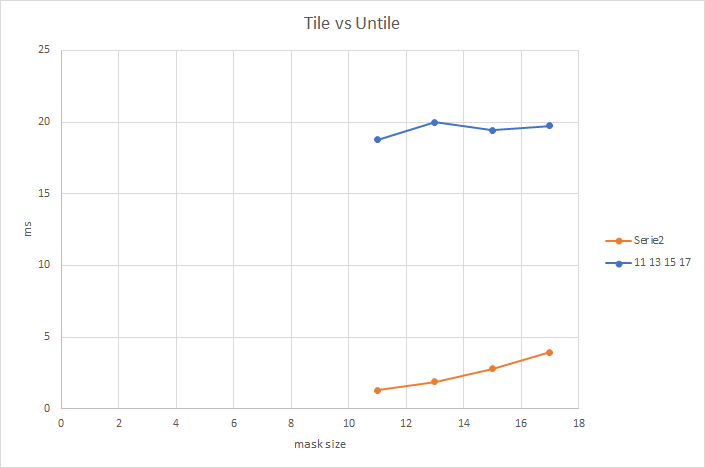